In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 2: Set dataset path
import os
dataset_path = '/content/drive/MyDrive/Gunshots'



In [ ]:
# Step 3: Load audio files and labels
import librosa
import numpy as np

audio_data = []
labels = []
classes = sorted(os.listdir(dataset_path))  # Automatically gets 9 classes

for label_idx, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for file in os.listdir(class_dir):
            if file.endswith('.wav'):
                file_path = os.path.join(class_dir, file)
                y, sr = librosa.load(file_path, sr=None)  # Load with original sampling rate
                audio_data.append(y)
                labels.append(label_idx)

print(f"Loaded {len(audio_data)} audio files across {len(classes)} classes.")

Loaded 851 audio files across 9 classes.


In [ ]:
# To get class names from label indices
label_to_class = {i: name for i, name in enumerate(classes)}


In [ ]:
# Extract MFCC features from each .wav file
X = []  # Initialize X as an empty list
y = []  # Initialize y as an empty list

for label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for file in os.listdir(class_dir):
            if file.endswith('.wav'):
                file_path = os.path.join(class_dir, file)
                signal, sr = librosa.load(file_path, sr=22050)

                # Extract 40 MFCCs
                mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
                mfcc = mfcc.T  # Transpose to shape (time_steps, features)

                # Pad or truncate to fixed length (e.g., 130 frames)
                if mfcc.shape[0] < 130:
                    pad_width = 130 - mfcc.shape[0]
                    mfcc = np.pad(mfcc, pad_width=((0, pad_width), (0, 0)), mode='constant')
                else:
                    mfcc = mfcc[:130, :]

                X.append(mfcc) # Append to the list X
                y.append(label) # Append to the list y

print(f"Extracted {len(X)} samples.")


Extracted 851 samples.


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convert to arrays
X = np.array(X)  # Shape: (num_samples, 130, 40)
y = to_categorical(y, num_classes=len(classes))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(130, 40)),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(64),
    Dropout(0.3),
    BatchNormalization(),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(len(classes), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 130, 128)            │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 130, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 130, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,449 (552.54 KB)

 Trainable params: 141,065 (551.04 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32)


Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - accuracy: 0.1297 - loss: 2.5584 - val_accuracy: 0.1170 - val_loss: 2.1798
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step - accuracy: 0.1817 - loss: 2.2597 - val_accuracy: 0.2164 - val_loss: 2.0618
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 0.2450 - loss: 1.9333 - val_accuracy: 0.3977 - val_loss: 1.9509
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step - accuracy: 0.2947 - loss: 1.8452 - val_accuracy: 0.3860 - val_loss: 1.8905
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.2999 - loss: 1.7184 - val_accuracy: 0.3801 - val_loss: 1.6776
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.3501 - loss: 1.5817 - val_accuracy: 0.3333 - val_loss: 1.7201
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.4113 - loss: 1.4421 - val_accuracy: 0.4094 - val_loss: 1.5394
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step - accuracy: 0.4640 - loss: 1.2952 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8094 - loss: 0.4530
Test Accuracy: 0.80


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step
                  precision    recall  f1-score   support

           AK-12       1.00      1.00      1.00        20
           AK-47       0.93      0.93      0.93        14
IMI Desert Eagle       0.86      0.95      0.90        20
             M16       0.00      0.00      0.00        20
            M249       0.88      0.75      0.81        20
              M4       0.49      1.00      0.66        20
           MG-42       0.76      0.95      0.84        20
             MP5       0.93      0.70      0.80        20
     Zastava M92       1.00      0.94      0.97        17

        accuracy                           0.80       171
       macro avg       0.76      0.80      0.77       171
    weighted avg       0.75      0.80      0.76       171



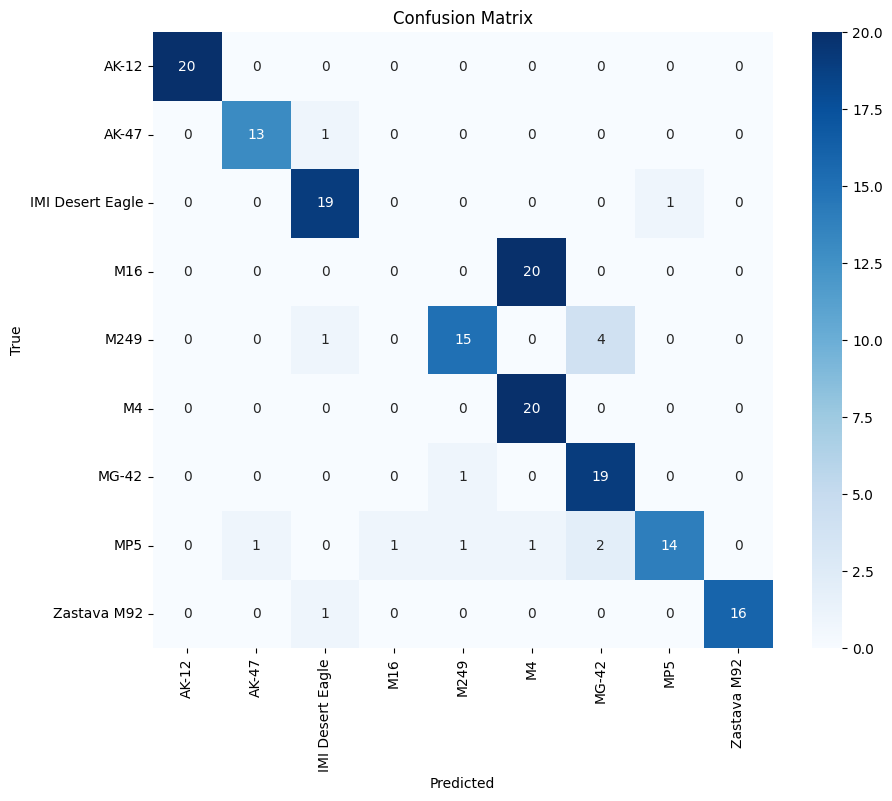

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict classes
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


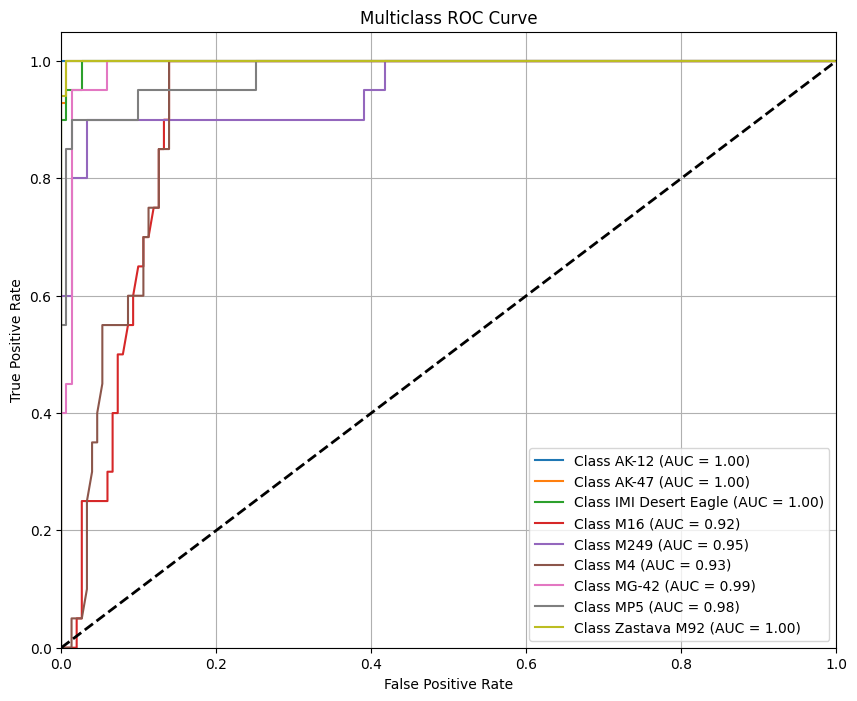

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels for ROC
y_test_bin = label_binarize(y_true, classes=list(range(len(classes))))
y_pred_bin = y_pred_probs  # Already softmax probs

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classes)

# Calculate FPR, TPR, AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
from statsmodels.stats.weightstats import ztest
import numpy as np
# Make sure you're using X_test, not full X
mfcc_class_0 = [np.mean(x) for i, x in enumerate(X_test) if y_true[i] == 0]
mfcc_class_1 = [np.mean(x) for i, x in enumerate(X_test) if y_true[i] == 1]


z_stat, p_value = ztest(mfcc_class_0, mfcc_class_1)
print(f"Z-statistic = {z_stat:.3f}, P-value = {p_value:.3f}")


Z-statistic = -0.387, P-value = 0.698


In [ ]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(mfcc_class_0, mfcc_class_1, equal_var=False)  # Welch's t-test
print(f"T-statistic = {t_stat:.3f}, P-value = {p_val:.3f}")


T-statistic = -0.356, P-value = 0.725


In [ ]:
from scipy.stats import f_oneway
import numpy as np

# Assuming y_true = np.argmax(y_test, axis=1) — matches X_test
group_data = []

# Use all 9 classes, or a subset like range(3)
for label in range(3):  # or range(9) for all classes
    group = [np.mean(x) for i, x in enumerate(X_test) if y_true[i] == label]
    group_data.append(group)

# Perform ANOVA
f_stat, p_value = f_oneway(*group_data)
print(f"ANOVA F-statistic = {f_stat:.3f}, P-value = {p_value:.3f}")


ANOVA F-statistic = 21.166, P-value = 0.000
